In [1]:
import os
import sys
from pathlib import Path
path = str(Path(os.getcwd()))
sys.path.insert(1, path+'/amazon-braket-community-detection/src')

In [2]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy.distance import geodesic
import networkx as nx

df = pd.read_csv(path+'/database/SolarPowerPlants_TH.csv', delimiter=',', skiprows=1)
df

,WKT,Index,latitude,longitude,name,capacity(MW),year PV energy production,Price(0.057/kWh)(USD),Num. Solar panel,Total price
0,POINT (100.1995973 13.5797688),1,13.579769,100.199597,Samut Sakhon,5.0,1408.14,80.26398,10000,802639.800
1,POINT (100.4800113 13.7131258),2,13.713126,100.480011,The Mall - Tha Phra,1.0,1408.99,80.31243,2000,160624.860
2,POINT (100.4474445 13.8199492),3,13.819949,100.447445,Ratchaphruek,1.0,1390.08,79.23456,2000,158469.120
3,POINT (100.5417601 13.8550947),4,13.855095,100.541760,The Mall - Ngamwongwan,1.0,1385.64,78.98148,2000,157962.960
4,POINT (100.6421705 13.7658514),5,13.765851,100.642171,The Mall - Bangkapi,1.0,1385.64,78.98148,2000,157962.960
5,POINT (100.6798205 13.8282182),6,13.828218,100.679821,Akekamai-Ramintra,1.0,1385.15,78.95355,2000,157907.100
6,POINT (101.0033703 13.5759609),7,13.575961,101.003370,Chachoengsao,1.3,1353.26,77.13582,2600,200553.132
7,POINT (100.5528226 14.1690859),8,14.169086,100.552823,Bangchak,16.0,1371.40,78.16980,32000,2501433.600
8,POINT (100.5530586 14.1689819),9,14.168982,100.553059,Bangchak III,25.0,1371.40,78.16980,50000,3908490.000
9,POINT (100.1837652 13.9754302),10,13.975430,100.183765,Sai Thong,6.1,1378.22,78.55854,12200,958414.188


In [3]:
ind = df['Index']
name = df['name']
lat = df['latitude']
long = df['longitude']
capacity = df['capacity(MW)']
penetration = df['Total price']


In [4]:
locations = {ind: (lat, long) for ind, lat, long in zip(ind, lat, long)}
locations

{1: (13.5797688, 100.1995973),
 2: (13.7131258, 100.4800113),
 3: (13.8199492, 100.4474445),
 4: (13.8550947, 100.5417601),
 5: (13.7658514, 100.6421705),
 6: (13.8282182, 100.6798205),
 7: (13.5759609, 101.0033703),
 8: (14.1690859, 100.5528226),
 9: (14.1689819, 100.5530586),
 10: (13.9754302, 100.1837652),
 11: (13.9840662, 100.1962857),
 12: (14.0004893, 100.200201),
 13: (14.1076288, 100.1737777),
 14: (14.1367617, 100.1432434),
 15: (14.1383847, 100.1506249),
 16: (14.1542604, 100.1377288),
 17: (14.2224476, 100.1128729),
 18: (14.2446193, 100.1275879),
 19: (14.3219005, 100.3022163),
 20: (14.2172742, 100.2778664)}

In [5]:
(len(locations.keys()))

20

In [6]:

# noconsumers = 10
# c_energy = np.random.default_rng().normal(loc=np.average(capacity), scale=np.std(capacity)/2, size=noconsumers)
# # c_energy = np.random.default_rng().integers(low=min(capacity), high=max(capacity), size=10)
# c_energy

In [7]:
def calculate_distance_mgpp(mglat, mglong, pplat, pplong):    
    distance_matrix = np.zeros(len(pplat))
    for i in range(len(pplat)):
        distance_matrix[i] = geodesic((mglat, mglong), (pplat[i], pplong[i])).km
    return distance_matrix


In [8]:
def calculate_distance_mgmg(mglat, mglong):    
    distance_matrix = np.zeros((len(mglat), len(mglat)))
    for i in range(len(mglat)):
        for j in range(len(mglat)):
            if i < j:
                distance_matrix[i][j] = geodesic((mglat[i], mglong[i]), (mglat[j], mglong[j])).km
    return distance_matrix

In [9]:
# def create_transmission_network(locations, distance_matrix, threshold=45):
#     G = nx.Graph()
#     for i, label_i in enumerate(locations.keys()):
#         for j, label_j in enumerate(locations.keys()):
#             if i < j:
#                 if distance_matrix[i][j] < threshold: # Only add edge if distance is below threshold
#                     G.add_edge(label_i, label_j)
#     return G

In [10]:
print(enumerate(locations.keys()))

In [11]:
# distance_matrix = calculate_distance_matrix(lat, long)

# # Create Graph Based on Distance Threshold
# G = create_transmission_network(locations, distance_matrix, threshold=45)

# # Visualize Graph
# fig, ax = plt.subplots()
# pos = {label: (lon, lat) for label, (lat, lon) in locations.items()}
# nx.draw(G, pos, ax=ax, node_size=100, node_color='blue')
# # nx.draw(G, pos, ax=ax, node_size=800, with_labels=True)
# # with_labels=True, node_color='lightblue', node_size=800)
# plt.title("Solar Panel Proximity Graph")
# plt.show()

In [12]:
# total_nodes = len(G.nodes(data=True))
# total_edges = len(G.edges(data=True))

In [13]:
import scipy.sparse as sp
from networkx.algorithms import community

### create QUBO matrix
# define the distance matrix
num_powerplants = (len(locations.keys())) ## number of solar power plants
pplat, pplong = zip(*locations.values())

In [14]:
# generate choices for microgrid locations
num_microgrids = 20 ## number of microgrids
random_lat = np.random.uniform(min(lat), max(lat), size=4*num_microgrids)
lat_choices = np.random.choice(random_lat, size=num_microgrids, replace=False)

random_long = np.random.uniform(min(long), max(long), size=4*num_microgrids)
long_choices = np.random.choice(random_long, size=num_microgrids, replace=False)

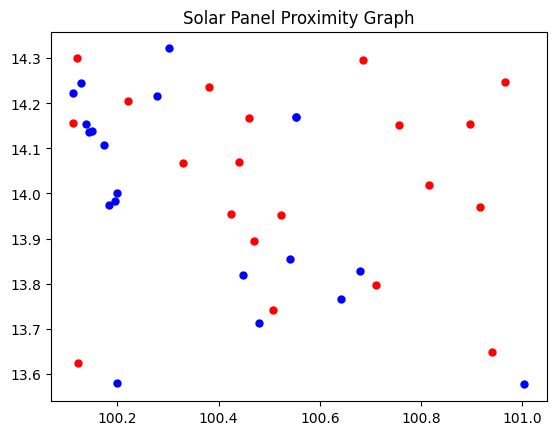

In [15]:
# Visualize Graph
fig, ax = plt.subplots()
ax.plot(long, lat, 'o', markersize=5, color='blue')
ax.plot(long_choices, lat_choices, 'o', markersize=5, color='red')
plt.title("Solar Panel Proximity Graph")
plt.show()

In [16]:
mgpp_distance = np.zeros(num_microgrids)
for i in range(num_microgrids):
    mgpp_distance[i] = np.sum(calculate_distance_mgpp(lat_choices[i], long_choices[i],pplat, pplong))
mgpp_distance

array([ 755.53035905, 1347.9829754 , 1543.39242674, 1146.24801532,
        637.41847407, 1040.26157997,  735.90520204,  906.19481859,
        692.20471798,  751.82610104, 1151.56829327, 1367.61347136,
        728.8673528 , 1561.20320585,  880.94336713,  684.64989959,
       1124.2977499 ,  773.39783634, 1167.38643636,  707.60064919])

In [17]:
mgmg_distance = calculate_distance_mgmg(lat_choices, long_choices)
mgmg_distance

array([[  0.        ,  54.0020486 ,  77.34296898,  70.4601582 ,
         17.91992451,  49.21373577,  37.47958726,  39.41756677,
         11.02331605,  24.82565316,  28.17837553,  47.04719795,
         30.30037743,  55.32214973,  47.48946574,  24.01117759,
         32.0224813 ,  11.49481997,  41.71352333,  26.07163478],
       [  0.        ,   0.        ,  35.55112982,  94.09570118,
         64.46578273,  29.31721822,  89.27055908,  93.40630037,
         52.65548141,  42.47385498,  44.10141759,  20.64168376,
         48.9566244 ,  31.35629989,  50.84652653,  53.19292245,
         26.70678398,  65.03998411,  12.30477144,  79.5085383 ],
       [  0.        ,   0.        ,   0.        ,  88.50160796,
         80.71496386,  29.62350151, 105.55758129, 114.10636026,
         71.28570076,  56.07256831,  76.85373408,  56.18103048,
         57.5259789 ,  66.43548623,  47.71945972,  65.06011635,
         59.1845298 ,  88.78080078,  43.13138819,  99.0876441 ],
       [  0.        ,   0.        ,  

In [18]:
costCoeff = 10000
mgpp_cost = mgpp_distance * costCoeff
mgmg_cost = mgmg_distance * costCoeff

battery_cost = 38000  # Example fixed cost for battery and inverter installation
solar_cost = 15000  # Example fixed cost for solar panel installation
fixedCost = battery_cost + solar_cost

In [19]:
np.array(penetration)

array([ 802639.8  ,  160624.86 ,  158469.12 ,  157962.96 ,  157962.96 ,
        157907.1  ,  200553.132, 2501433.6  , 3908490.   ,  958414.188,
        471395.7  , 1131538.464, 5639930.208, 3738735.336, 1523781.342,
       1869693.252, 1100657.46 ,  157290.36 ,  267252.138,  471980.52 ])

In [20]:
### QUBO matrix
term1 = (fixedCost*np.ones((1, num_microgrids))) + np.array(penetration) - mgpp_cost
linearTerm = np.zeros((num_microgrids, num_microgrids))
for i in range(num_microgrids):
    linearTerm[i,i] = term1[0,i]
quandTerm = mgmg_cost
qubo_matrix = linearTerm + quandTerm

In [21]:
from autoqubo import SamplingCompiler, Utils

In [22]:
solutions, energy_values = Utils.solve(qubo_matrix)
for s, e in zip(solutions, energy_values):
    print(f"x={s}, energy={e}")

x=[1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0], energy=-96964598.28107142


In [24]:
np.shape(solutions)

(1, 20)